<a href="https://colab.research.google.com/github/Deygoms/TimeSeries-GenerationSolar/blob/main/TrabajoF_seriesT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo final - Análisis de series de tiempo**

---
* **Estudiante 1:** -Deyson Gomez Sanchez
* **Estudiante 2:** -Elizabeth Moreno Bohorquez

# Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Datos

In [2]:
# Frecuencia de muestreo: 1 muestra por hora
dt = 1.0  # Delta tiempo en horas
fs = 1/dt  # Hz (1/hora)


In [3]:
df = pd.read_csv('/content/Datosnuevos.csv', sep=';', parse_dates=['Timestamp'],
                 index_col='Timestamp', encoding='latin-1', decimal=',',dayfirst=True)
# Extraer la serie de radiación solar
# pd.to_numeric convierte valores a números, errors='coerce' convierte valores no numéricos a NaN
radiacion = df['Radiacion [Wh/m2]']
potencia = df['Generación [Kwh]']
# Reemplazar NaN con 0 si existen
radiacion = np.nan_to_num(radiacion, nan=0.0)
tiempo=df.index.dayofyear + df.index.hour/24 + df.index.minute/(24*60)
tiempo.unique()
potencia = np.nan_to_num(potencia, nan=0.0)




Total de muestras: 745


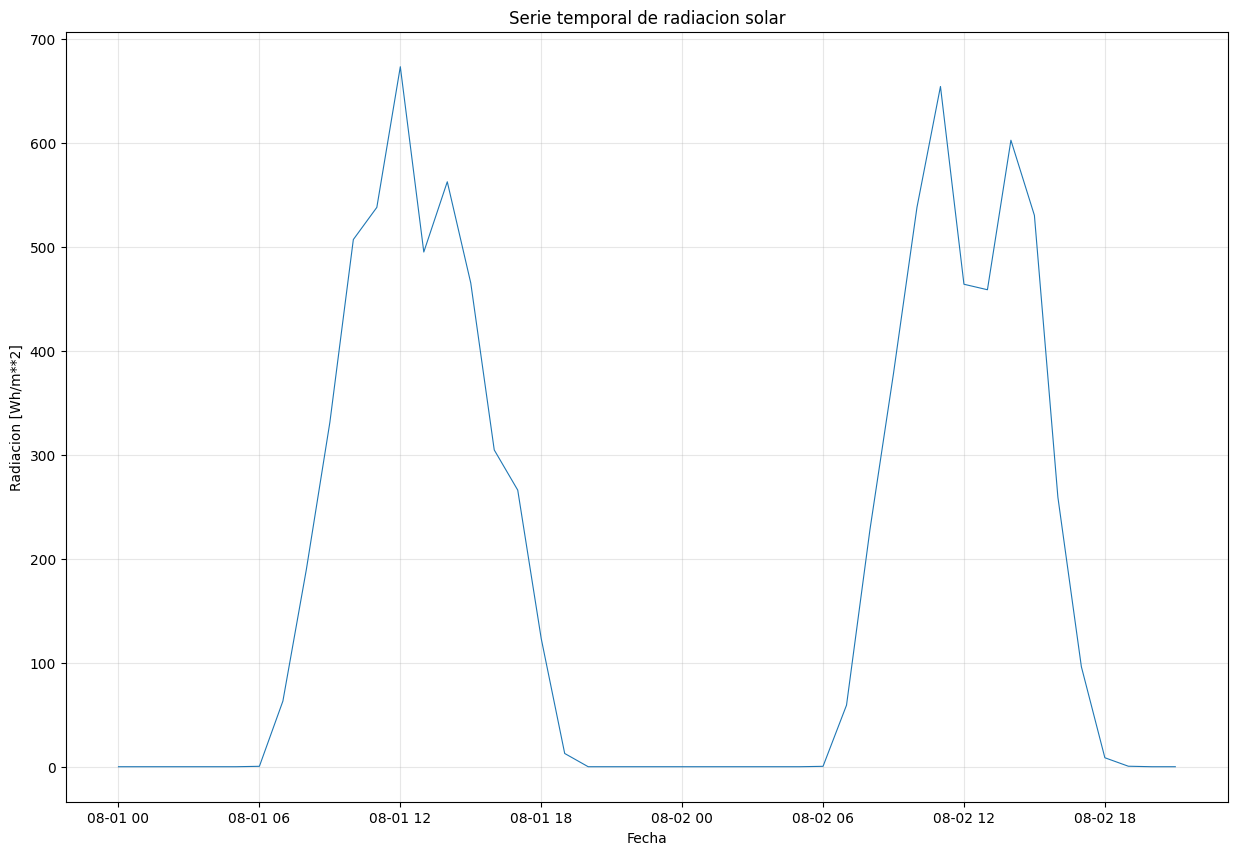

In [14]:
# Número total de muestras
N = len(radiacion)
print(f"Total de muestras: {N}")
plt.figure(figsize=(15, 10))
plt.plot(df.index[0:23*2], radiacion[0:23*2], linewidth=0.8)
plt.xlabel('Fecha')
plt.ylabel('Radiacion [Wh/m**2]')
plt.title('Serie temporal de radiacion solar')
plt.grid(True, alpha=0.3)


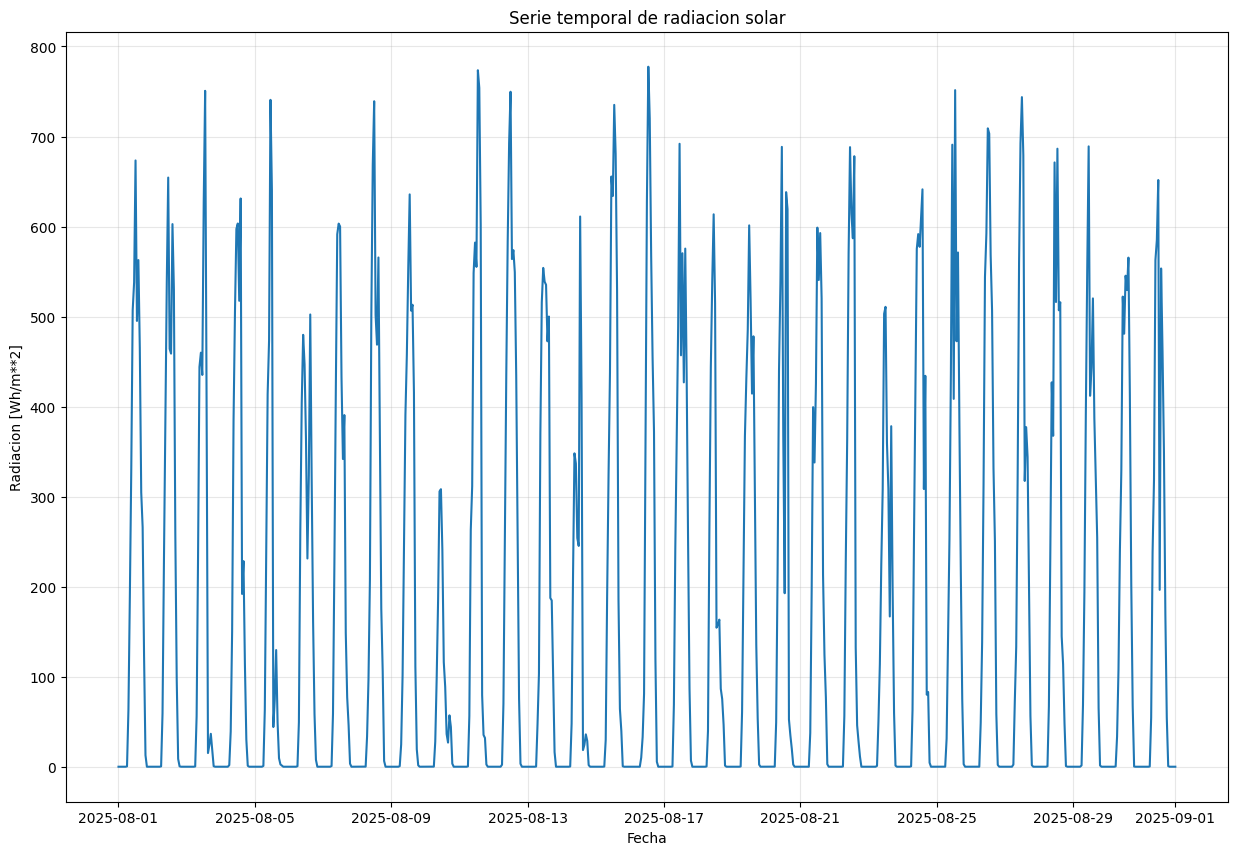

In [15]:
plt.figure(figsize=(15, 10))

plt.plot(df.index, radiacion)
plt.xlabel('Fecha')
plt.ylabel('Radiacion [Wh/m**2]')
plt.title('Serie temporal de radiacion solar')
plt.grid(True, alpha=0.3)

# Análisis expliratorio

In [16]:
print(f"\nEstadísticas de Irradiancia (datos diurnos):")
print(f"  - Media: {radiacion.mean():.2f} Wh/m²")
print(f"  - Mediana: {np.median(radiacion):.2f} Wh/m²")
print(f"  - Desviación estándar: {np.std(radiacion):.2f} Wh/m²")
print(f"  - Percentil 95: {np.percentile(radiacion,95):.2f} Wh/m²")
print(f"  - Percentil 99: {np.percentile(radiacion,99):.2f} Wh/m²")




Estadísticas de Irradiancia (datos diurnos):
  - Media: 166.44 Wh/m²
  - Mediana: 7.70 Wh/m²
  - Desviación estándar: 228.73 Wh/m²
  - Percentil 95: 625.26 Wh/m²
  - Percentil 99: 740.04 Wh/m²


In [17]:
print(max(radiacion))
print(min(radiacion))

777.525
0.0


# Transformada de fourier

Por defecto python hace:

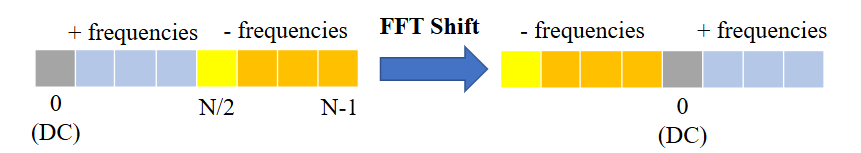

Por lo tanto el siguiente codigo organiza la FFT colocando las frecuencias negaticas a la izquierda


In [7]:
tfourier = np.fft.fft(radiacion)
tfourier_mag = np.abs(tfourier)
tfourier_phase = np.angle(tfourier)
# np.fft.fftfreq genera el array de frecuencias para N muestras con frecuencia de muestreo fs
freqs = np.fft.fftfreq(N, d=dt)
# Para tomar la parte positiva
tfourier_mag = tfourier_mag[:N//2]
tfourier_phase = tfourier_phase[:N//2]
timegraf=tiempo[:N//2]
freqs=freqs[:N//2]
period=1/freqs
periodos = np.zeros_like(freqs)
mask = freqs > 0
periodos[mask] = 1.0 / freqs[mask]


/tmp/ipython-input-174462222.py:11: RuntimeWarning: divide by zero encountered in divide
  period=1/freqs


Text(0.5, 1.0, 'Espectro de magnitud en función del periodo')

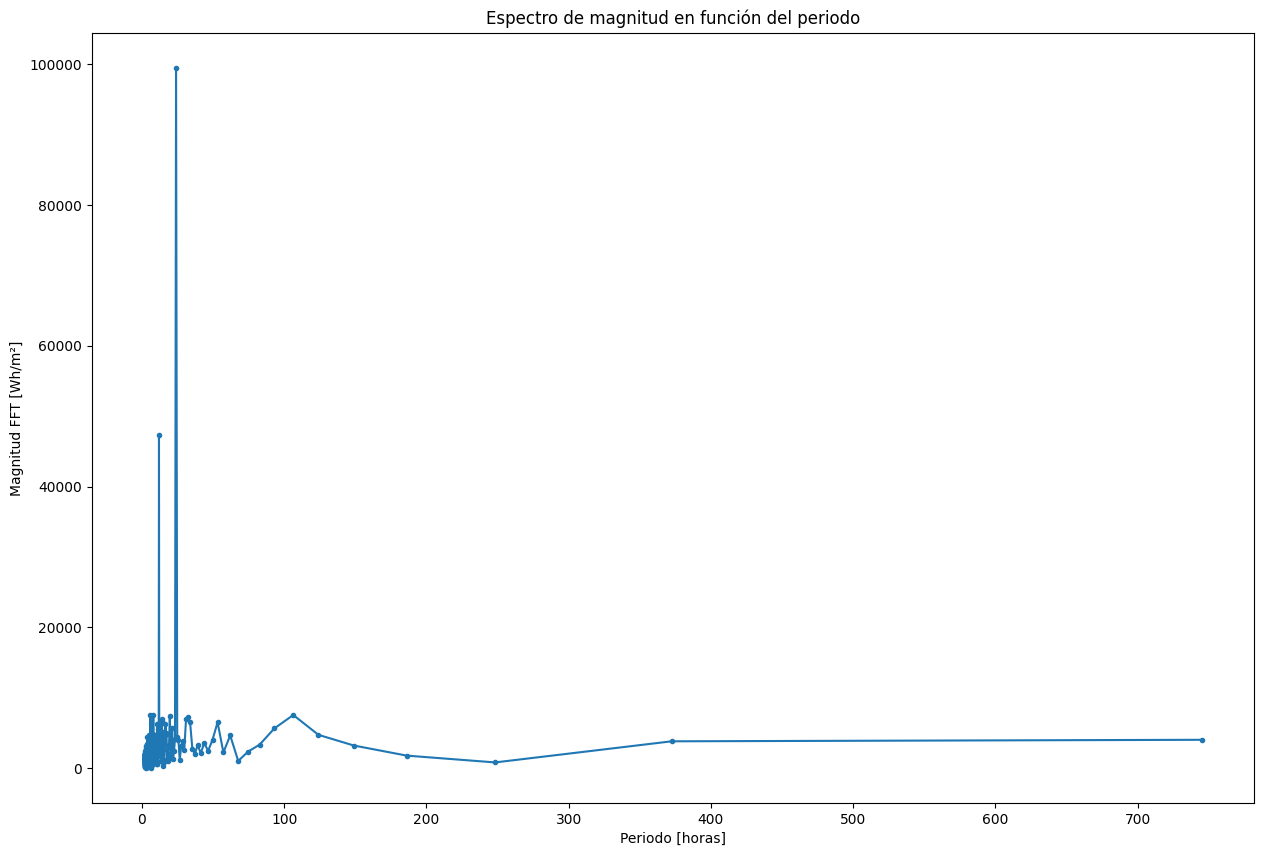

In [19]:
plt.figure(figsize=(15, 10))
plt.plot(period,tfourier_mag,'.-')
plt.xlabel('Periodo [horas]')
plt.ylabel('Magnitud FFT [Wh/m²]')
plt.title('Espectro de magnitud en función del periodo')



In [20]:
pos = np.argmax(tfourier_mag[1:]) + 1  # Excluye DC (componente 0)
print(f"Periodo dominante: {period[pos]:.2f}h")

Periodo dominante: 24.03h


In [21]:
# Calcular densidad espectral de potencia
psd = tfourier_mag ** 2

# Encontrar frecuencia dominante (excluyendo DC - componente 0)
idx_dominante = np.argmax(psd[1:]) + 1
freq_dominante = freqs[idx_dominante]
periodo_dominante = periodos[idx_dominante]

print("\n" + "="*70)
print("FRECUENCIA DOMINANTE:")
print("="*70)
print(f"Frecuencia: {freq_dominante:.6f} ciclos/hora")
print(f"Periodo: {periodo_dominante:.2f} horas ({periodo_dominante/24:.2f} días)")
print(f"Potencia: {psd[idx_dominante]:.2e}")

# Validación
if 23 <= periodo_dominante <= 25:
    print("Resultado: CORRECTO - Ciclo diario detectado (24h)")
else:
    print(f"ADVERTENCIA: Periodo dominante es {periodo_dominante:.2f}h, no 24h")
    print("Revisar datos o sensor")


FRECUENCIA DOMINANTE:
Frecuencia: 0.041611 ciclos/hora
Periodo: 24.03 horas (1.00 días)
Potencia: 9.90e+09
Resultado: CORRECTO - Ciclo diario detectado (24h)


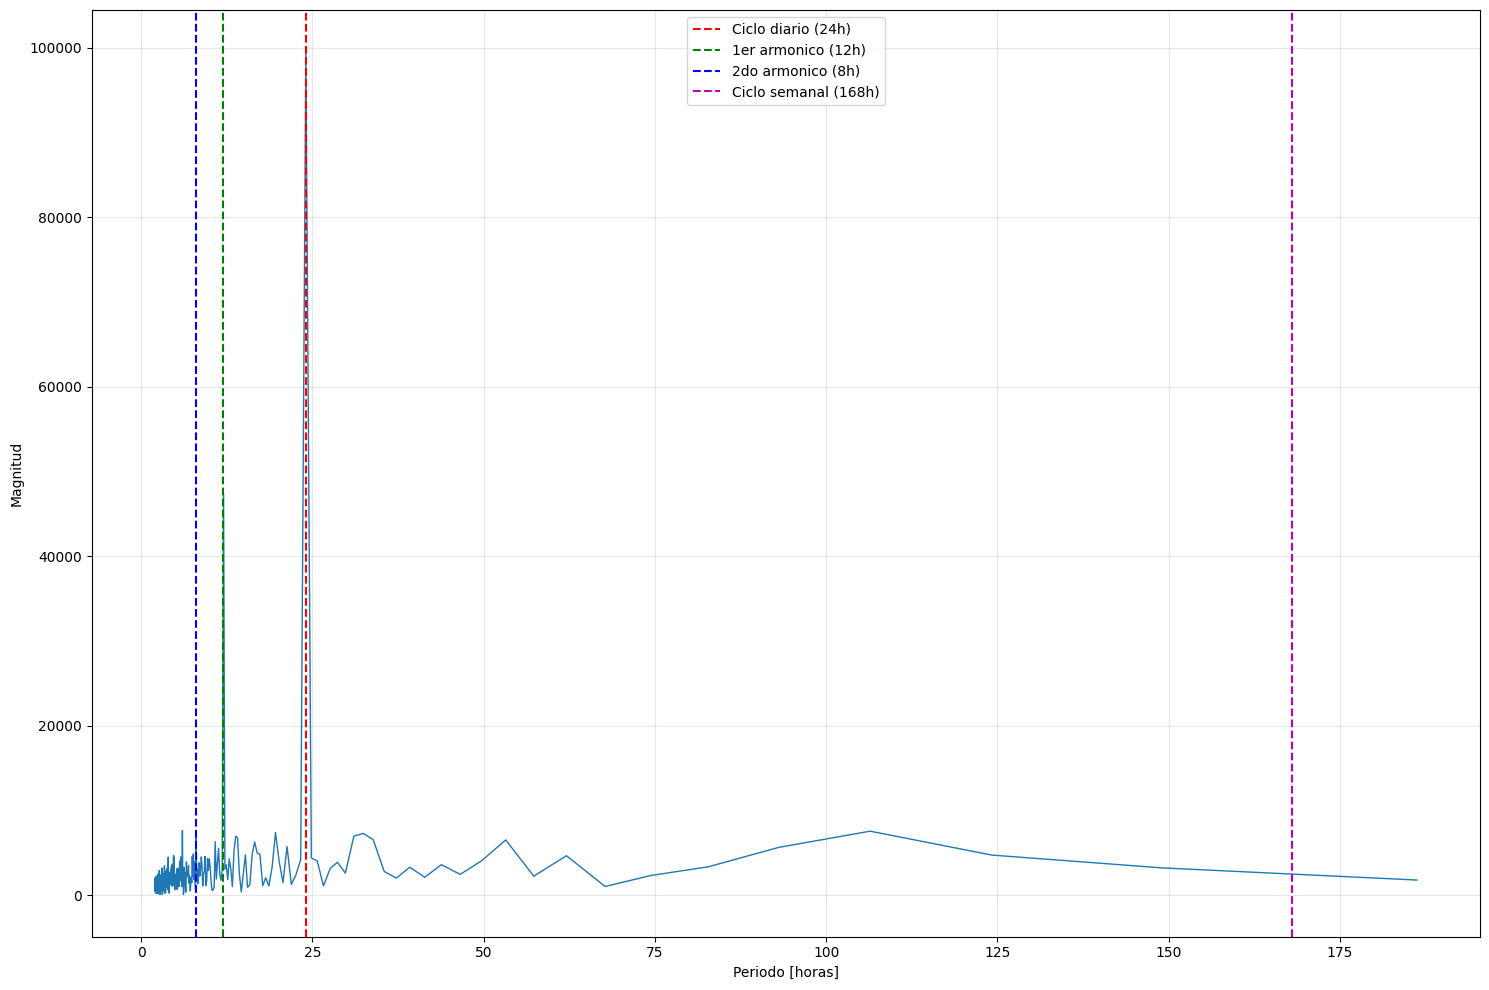

In [22]:

# Graficamos solo periodos entre 2 y 200 horas para ver ciclos relevantes
plt.figure(figsize=(15, 10))
mask_periodo = (periodos >= 2) & (periodos <= 200)
plt.plot(periodos[mask_periodo], tfourier_mag[mask_periodo], linewidth=1)
plt.xlabel('Periodo [horas]')
plt.ylabel('Magnitud')
#plt.title('Espectro de potencia en funcion del periodo')
plt.grid(True, alpha=0.3)

# Marcar periodos importantes
plt.axvline(x=24, color='r', linestyle='--', label='Ciclo diario (24h)')
plt.axvline(x=12, color='g', linestyle='--', label='1er armonico (12h)')
plt.axvline(x=8, color='b', linestyle='--', label='2do armonico (8h)')
plt.axvline(x=168, color='m', linestyle='--', label='Ciclo semanal (168h)')
"""
plt.axvline(x=periodo_dominante, color='black', linestyle='-', linewidth=2.5,
            label=f'Dominante: {periodo_dominante:.1f}h', alpha=0.8)
"""
plt.legend()

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Espectro de potencia en función del periodo')

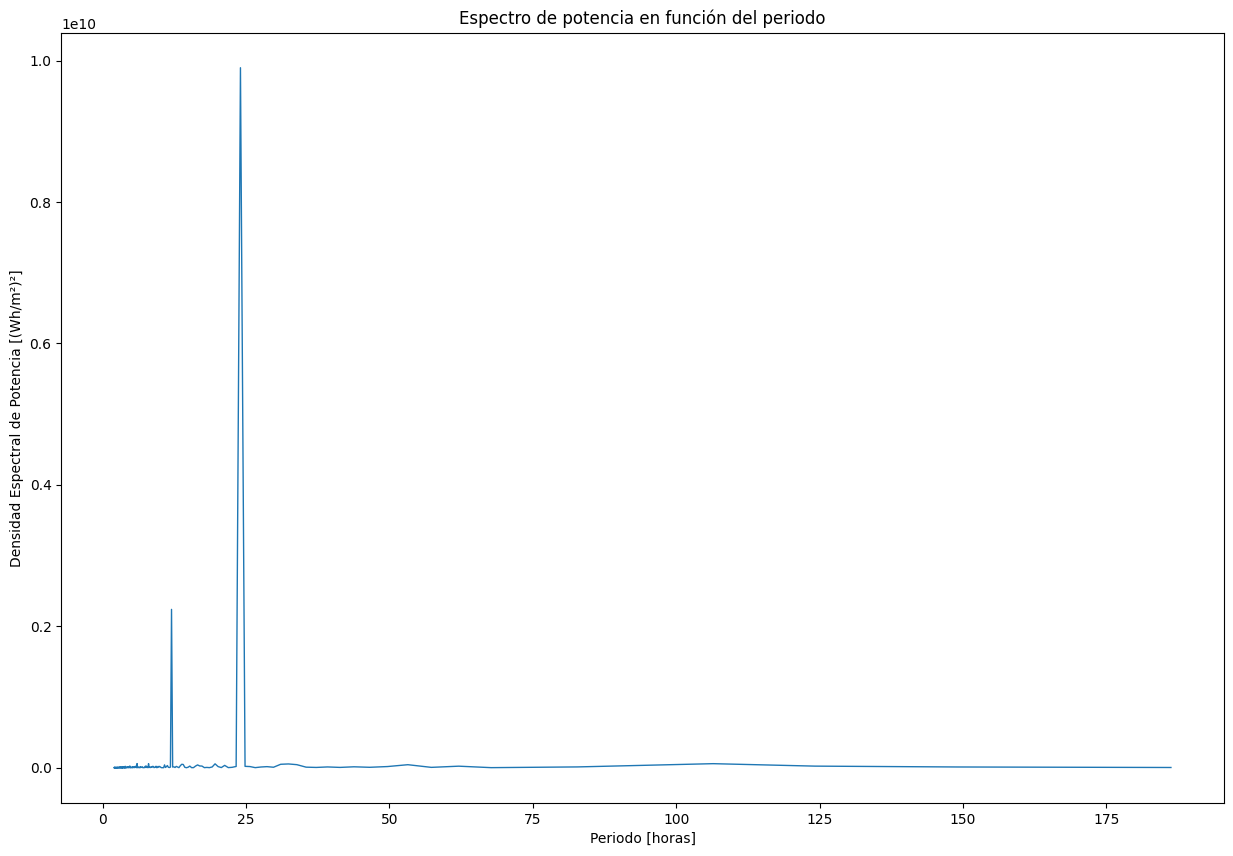

In [23]:
plt.figure(figsize=(15, 10))
mask_periodo = (periodos >= 2) & (periodos <= 200)
plt.plot(periodos[mask_periodo], psd[mask_periodo], linewidth=1)
plt.xlabel('Periodo [horas]')
plt.ylabel('Densidad Espectral de Potencia [(Wh/m²)²]')
plt.title('Espectro de potencia en función del periodo')

# componentes de la FFT


Graficando las 20 componentes más significativas
Ventana temporal: 30.0 días



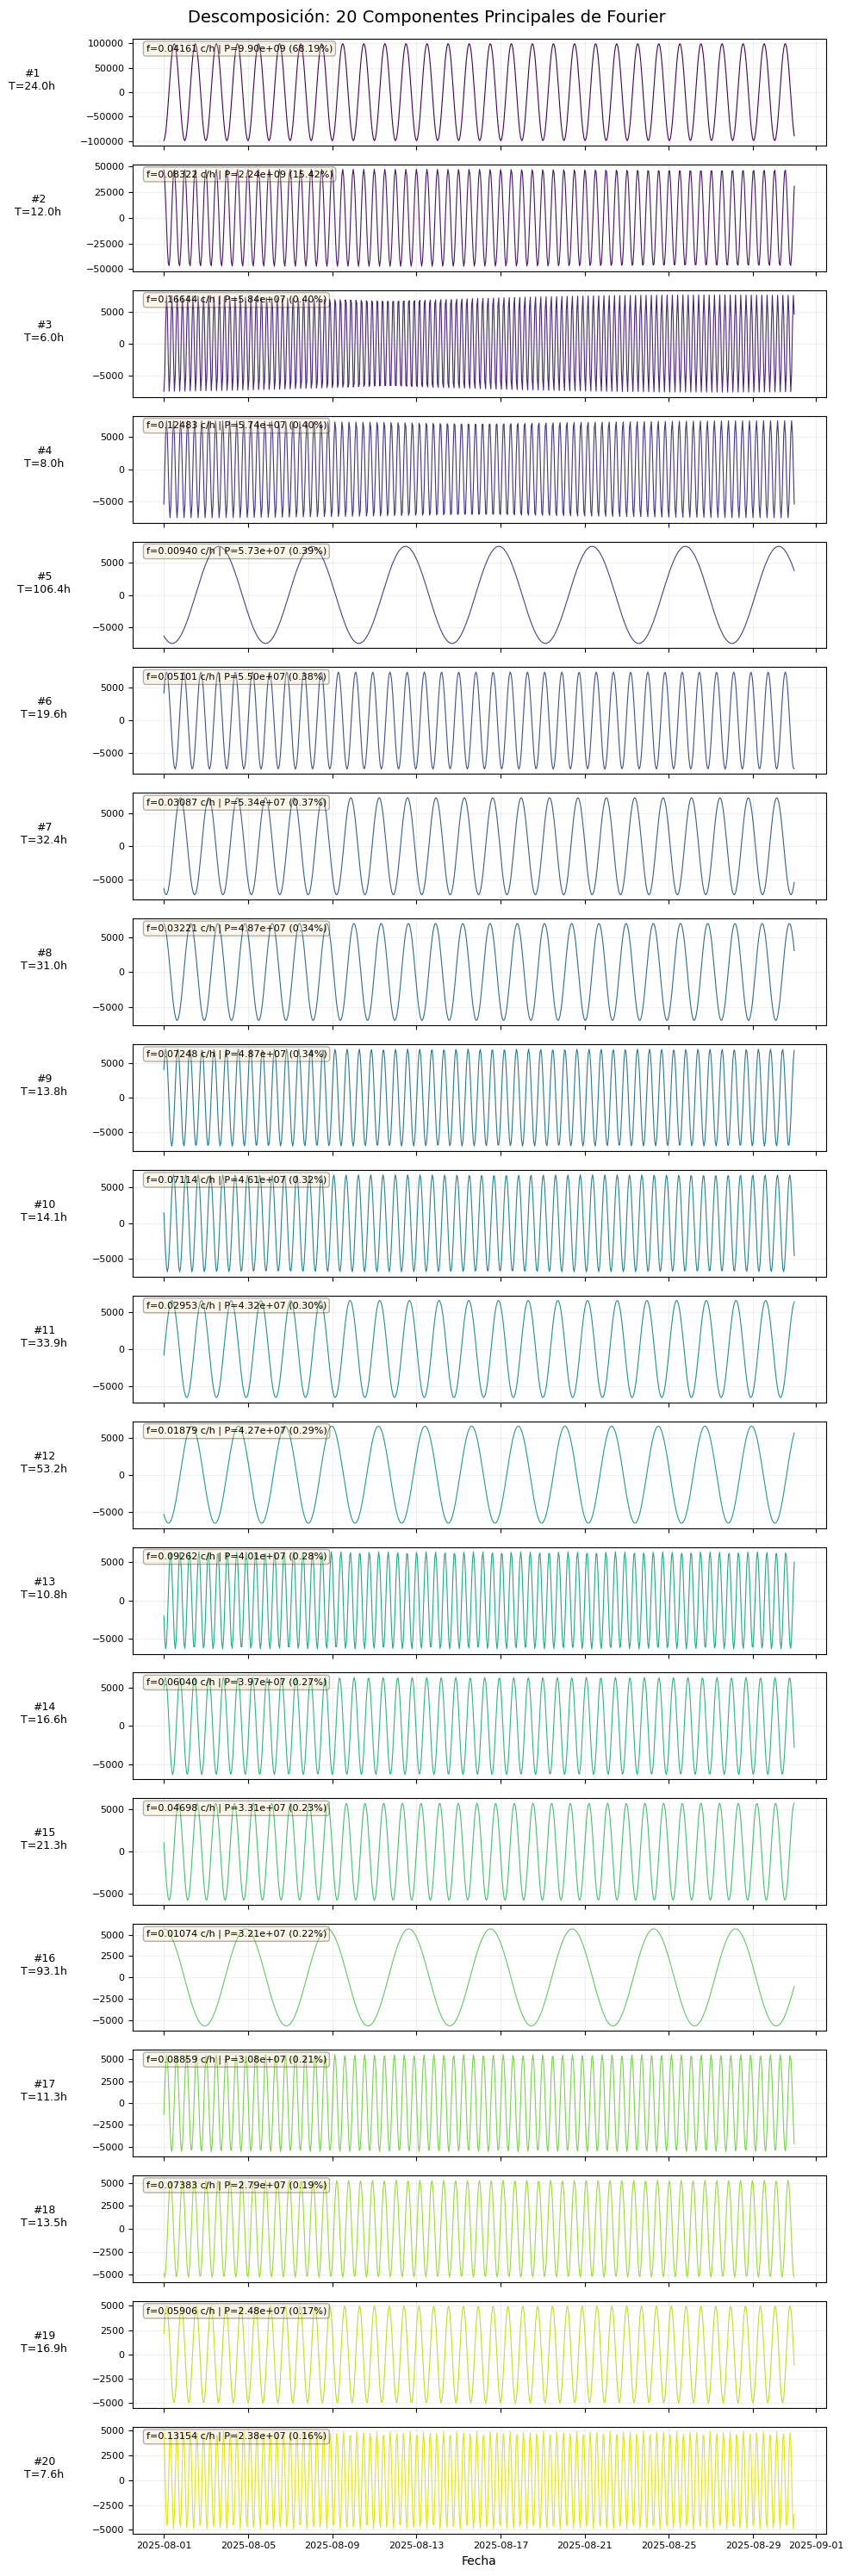

In [ ]:
n_componentes_graficar = 20

# Ordenar componentes por potencia (excluyendo DC - componente 0)
indices_ordenados = np.argsort(psd[1:])[::-1] + 1
indices_seleccionados = indices_ordenados[:n_componentes_graficar]

# Ventana temporal para graficar (en horas)
ventana_inicio = 0
ventana_fin = 30 * 24  # dias*horas
tiempo_horas = np.arange(ventana_inicio, ventana_fin)

print(f"\nGraficando las {n_componentes_graficar} componentes más significativas")
print(f"Ventana temporal: {ventana_fin/24:.1f} días\n")

# Crear figura con subplots
fig, axes = plt.subplots(n_componentes_graficar, 1,
                         figsize=(10, n_componentes_graficar*1.5))
#figsize=(20, n_componentes_graficar * 1.5))
# Si solo es 1 componente, axes no es array
if n_componentes_graficar == 1:
    axes = [axes]

for i, idx in enumerate(indices_seleccionados):
    # Extraer parámetros del componente
    A = tfourier_mag[idx]  # Amplitud
    fase = tfourier_phase[idx]  # Fase
    freq = freqs[idx]  # Frecuencia (ciclos/hora)
    periodo = periodos[idx]  # Periodo (horas)

    # Reconstruir componente: A * cos(2π*f*t + fase)
    # Factor 2/N para normalización correcta
    #componente = (2 * A / N) * np.cos(2 * np.pi * freq * tiempo_horas + fase)
    # sin normalizar
    componente = A * np.cos(2 * np.pi * freq * tiempo_horas + fase)

    # Graficar
    axes[i].plot(df.index[ventana_inicio:ventana_fin],
                 componente,
                 linewidth=0.8,
                 color=plt.cm.viridis(i/n_componentes_graficar))

    # Etiquetas
    axes[i].set_ylabel(f'#{i+1}\nT={periodo:.1f}h',
                      rotation=0, labelpad=40, fontsize=9)
    axes[i].grid(True, alpha=0.2)
    axes[i].tick_params(labelsize=8)


    # Mostrar info en el título de cada subplot
    potencia_porcentaje = (psd[idx] / np.sum(psd[1:])) * 100
    axes[i].text(0.02, 0.95,
                f'f={freq:.5f} c/h | P={psd[idx]:.2e} ({potencia_porcentaje:.2f}%)',
                transform=axes[i].transAxes,
                fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    # Solo mostrar xlabel en el último subplot
    if i < n_componentes_graficar - 1:
        axes[i].set_xticklabels([])
    else:
        axes[i].set_xlabel('Fecha', fontsize=10)

fig.suptitle(f'Descomposición: {n_componentes_graficar} Componentes Principales de Fourier',
             fontsize=14, y=0.995)
plt.tight_layout()
#0.02, 0.95,

## Comparación de las señales

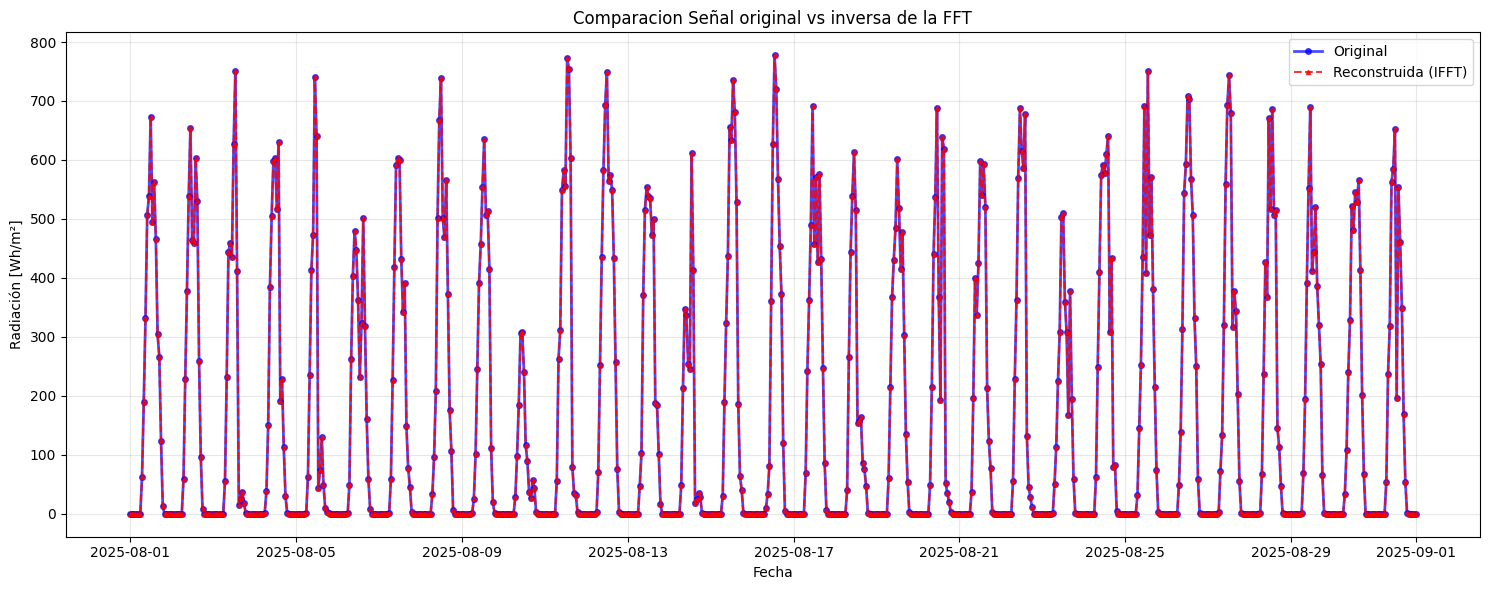

In [ ]:
# Aplicar transformada inversa
radiacion_reconstruida = np.fft.ifft(tfourier).real

# Zoom a 2 días para ver detalles
plt.figure(figsize=(15, 6))
plt.plot(df.index, radiacion, 'bo-', linewidth=2,
         markersize=4, label='Original', alpha=0.7)
plt.plot(df.index, radiacion_reconstruida, 'r^--', linewidth=1.5,
         markersize=3, label='Reconstruida (IFFT)', alpha=0.8)
plt.xlabel('Fecha')
plt.ylabel('Radiación [Wh/m²]')
plt.title('Comparacion Señal original vs inversa de la FFT')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [ ]:
# Calcular métricas de error
error_absoluto = np.abs(radiacion - radiacion_reconstruida)
error_relativo = np.mean(error_absoluto / (radiacion + 1e-10)) * 100  # Evitar división por 0
rmse = np.sqrt(np.mean(error_absoluto**2))

print(f"Error medio absoluto: {np.mean(error_absoluto):.6f} Wh/m²")
print(f"Error relativo promedio: {error_relativo:.6f}%")
print(f"RMSE: {rmse:.6f} Wh/m²")
print(f"Error máximo: {np.max(error_absoluto):.6e} Wh/m²")

Error medio absoluto: 0.000000 Wh/m²
Error relativo promedio: 0.047750%
RMSE: 0.000000 Wh/m²
Error máximo: 5.684342e-13 Wh/m²


In [13]:
# Buscar los 5 picos más importantes (excluyendo DC)
n_peaks = 5
indices_picos = np.argsort(psd[1:])[-n_peaks:][::-1] + 1

print("\n" + "="*70)
print(f"TOP {n_peaks} COMPONENTES FRECUENCIALES MÁS SIGNIFICATIVAS:")
print("="*70)
for i, idx in enumerate(indices_picos, 1):
    print(f"{i}. Periodo: {periodos[idx]:.2f}h | "
          f"Magnitud: {tfourier_mag[idx]:.2e} Wh/m² | "
          f"Potencia: {psd[idx]:.2e} (Wh/m²)²")

print("\n" + "="*70)


TOP 5 COMPONENTES FRECUENCIALES MÁS SIGNIFICATIVAS:
1. Periodo: 24.03h | Magnitud: 9.95e+04 Wh/m² | Potencia: 9.90e+09 (Wh/m²)²
2. Periodo: 12.02h | Magnitud: 4.73e+04 Wh/m² | Potencia: 2.24e+09 (Wh/m²)²
3. Periodo: 6.01h | Magnitud: 7.64e+03 Wh/m² | Potencia: 5.84e+07 (Wh/m²)²
4. Periodo: 8.01h | Magnitud: 7.58e+03 Wh/m² | Potencia: 5.74e+07 (Wh/m²)²
5. Periodo: 106.43h | Magnitud: 7.57e+03 Wh/m² | Potencia: 5.73e+07 (Wh/m²)²




RECONSTRUCCIÓN PROGRESIVA
Con   1 componentes: RMSE =   210.50 Wh/m² | Energía =   8.04%
Con   3 componentes: RMSE =   189.81 Wh/m² | Energía =  17.08%
Con   5 componentes: RMSE =   188.49 Wh/m² | Energía =  17.66%
Con  10 componentes: RMSE =   185.99 Wh/m² | Energía =  18.75%
Con  20 componentes: RMSE =   182.97 Wh/m² | Energía =  20.07%
Con  50 componentes: RMSE =   177.42 Wh/m² | Energía =  22.49%


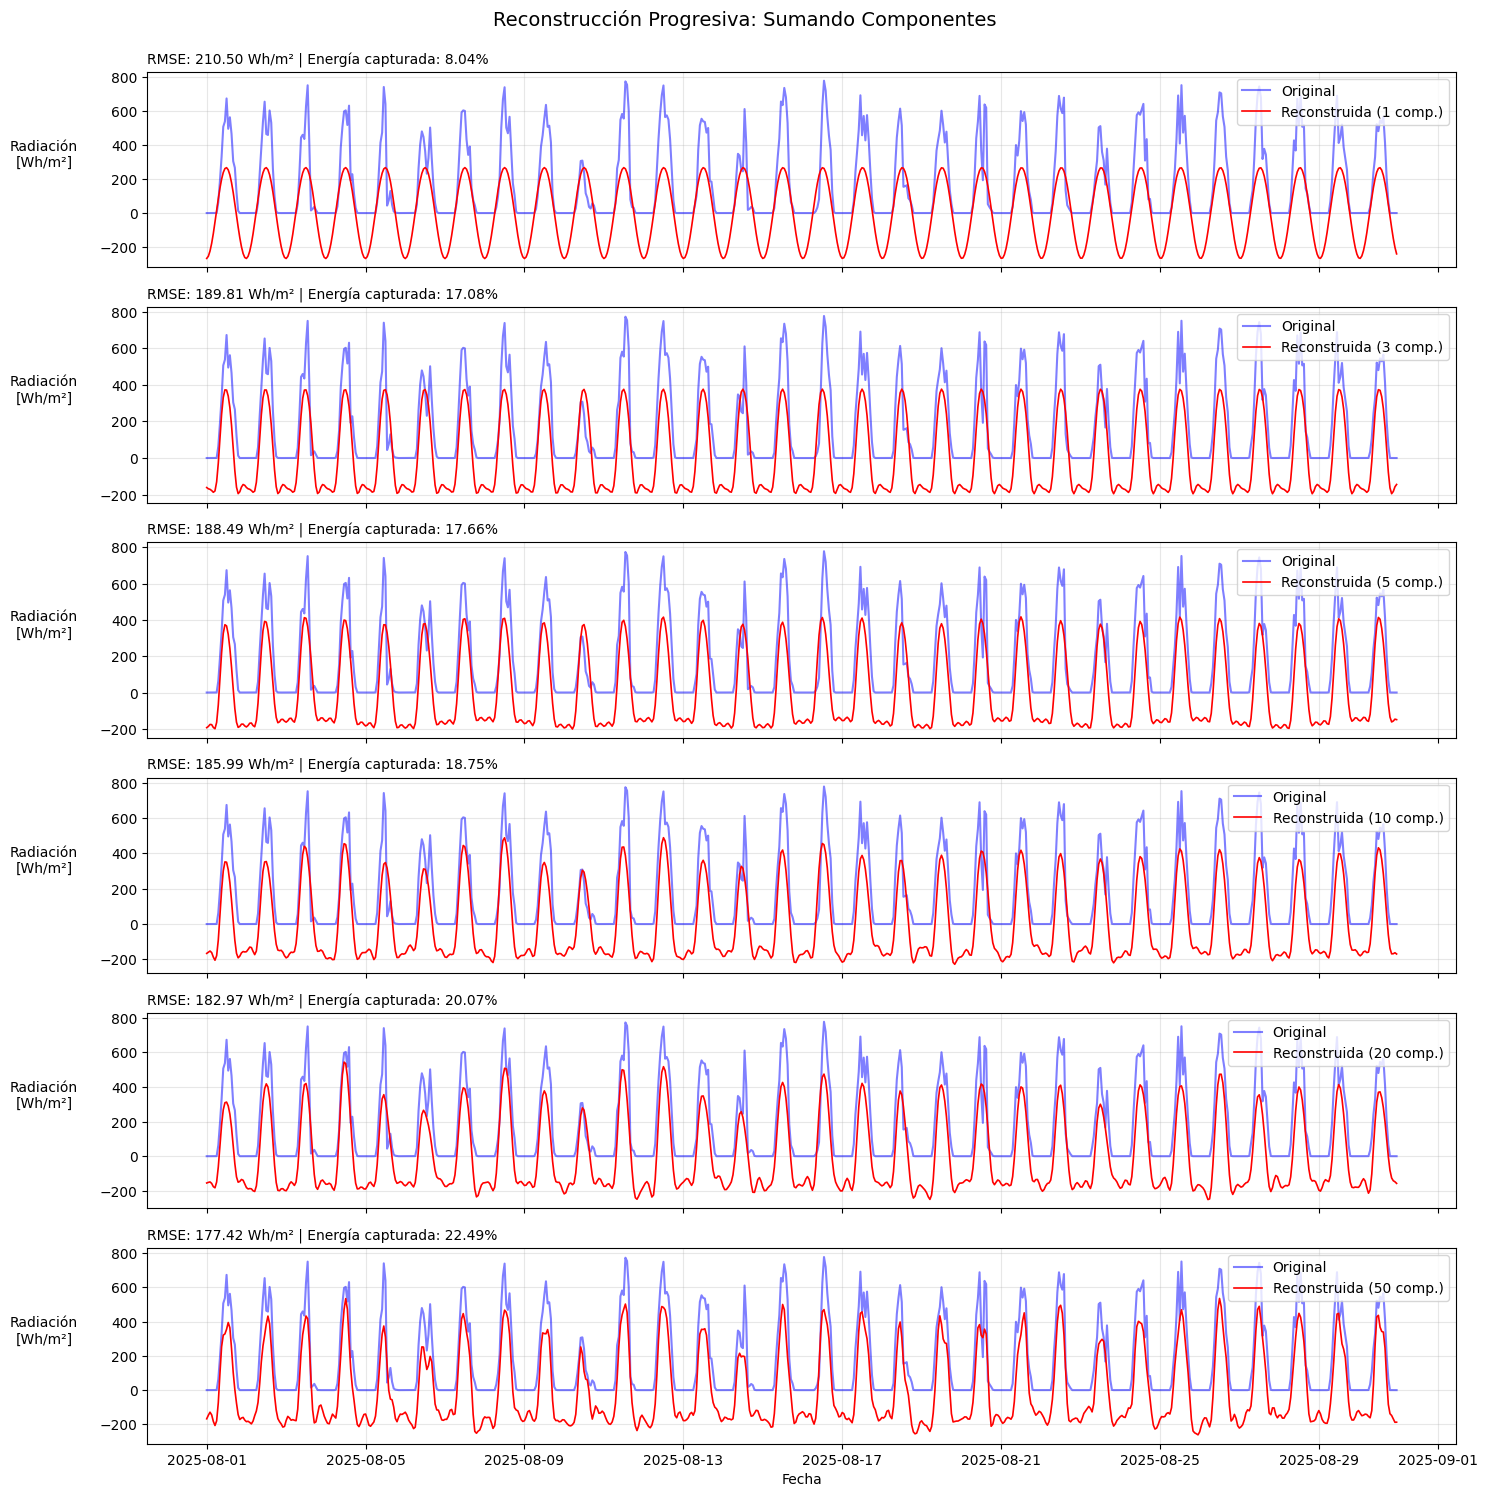

In [ ]:

print("\n" + "="*70)
print("RECONSTRUCCIÓN PROGRESIVA")
print("="*70)

# Número de pasos para mostrar reconstrucción progresiva
componentes_mostrar = [1, 3, 5, 10, 20, 50]  # Puedes ajustar
componentes_mostrar = [c for c in componentes_mostrar if c <= len(indices_ordenados)]

fig2, axes2 = plt.subplots(len(componentes_mostrar), 1,
                           figsize=(15, len(componentes_mostrar) * 2.5))

if len(componentes_mostrar) == 1:
    axes2 = [axes2]

for i, n_comp in enumerate(componentes_mostrar):
    # Reconstruir señal sumando las n_comp componentes más importantes
    señal_reconstruida_parcial = np.zeros(ventana_fin - ventana_inicio)

    for idx in indices_ordenados[:n_comp]:
        A = tfourier_mag[idx]
        fase = tfourier_phase[idx]
        freq = freqs[idx]
        componente = (2 * A / N) * np.cos(2 * np.pi * freq * tiempo_horas + fase)
        señal_reconstruida_parcial += componente

    # Graficar original vs reconstruida
    axes2[i].plot(df.index[ventana_inicio:ventana_fin],
                  radiacion[ventana_inicio:ventana_fin],
                  'b-', linewidth=1.5, alpha=0.5, label='Original')
    axes2[i].plot(df.index[ventana_inicio:ventana_fin],
                  señal_reconstruida_parcial,
                  'r-', linewidth=1.2, label=f'Reconstruida ({n_comp} comp.)')

    # Calcular error
    error = radiacion[ventana_inicio:ventana_fin] - señal_reconstruida_parcial
    rmse = np.sqrt(np.mean(error**2))
    energia_capturada = (1 - rmse/np.std(radiacion[ventana_inicio:ventana_fin])) * 100

    axes2[i].set_ylabel('Radiación\n[Wh/m²]', rotation=0, labelpad=40)
    axes2[i].legend(loc='upper right')
    axes2[i].grid(True, alpha=0.3)
    axes2[i].set_title(f'RMSE: {rmse:.2f} Wh/m² | Energía capturada: {energia_capturada:.2f}%',
                      fontsize=10, loc='left')

    if i < len(componentes_mostrar) - 1:
        axes2[i].set_xticklabels([])
    else:
        axes2[i].set_xlabel('Fecha')

    print(f"Con {n_comp:3d} componentes: RMSE = {rmse:8.2f} Wh/m² | "
          f"Energía = {energia_capturada:6.2f}%")

fig2.suptitle('Reconstrucción Progresiva: Sumando Componentes',
              fontsize=14, y=0.995)
plt.tight_layout()

graficar_todas = False  # Cambia a True si realmente quieres TODAS

if graficar_todas:
    print("\n" + "="*70)
    print("GRAFICANDO TODAS LAS COMPONENTES (ESTO PUEDE TARDAR)")
    print("="*70)

    # Número total de componentes (excluyendo DC)
    n_total = len(freqs[1:])

    # Limitar ventana temporal para que sea visible
    ventana_corta = 2 * 24  # Solo 2 días
    tiempo_corto = np.arange(0, ventana_corta)

    # Limitar número máximo para no saturar (opcional)
    max_componentes = min(100, n_total)  # Máximo 100 componentes

    fig3, axes3 = plt.subplots(max_componentes, 1,
                               figsize=(15, max_componentes * 0.5))

    print(f"Mostrando {max_componentes} de {n_total} componentes totales")
    print(f"Ventana: {ventana_corta/24:.1f} días\n")

    for i in range(max_componentes):
        idx = i + 1  # Empezar desde 1 (saltar DC)

        A = tfourier_mag[idx]
        fase = tfourier_phase[idx]
        freq = freqs[idx]

        componente = (2 * A / N) * np.cos(2 * np.pi * freq * tiempo_corto + fase)

        axes3[i].plot(tiempo_corto, componente, linewidth=0.5)
        axes3[i].set_ylabel(f'{i+1}', rotation=0, fontsize=6)
        axes3[i].set_yticks([])
        axes3[i].set_xticks([])
        axes3[i].spines['top'].set_visible(False)
        axes3[i].spines['right'].set_visible(False)

        if i < max_componentes - 1:
            axes3[i].spines['bottom'].set_visible(False)

    axes3[-1].set_xlabel('Tiempo [horas]')
    fig3.suptitle(f'Todas las Componentes de Fourier (primeras {max_componentes})',
                  fontsize=12)
    plt.tight_layout()

plt.show()